In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
import json

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud

import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk import tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
lyrics_labelled_data = pickle.load(open('../data/lyrics/lyrics_labelled_data.pkl', 'rb'))

In [3]:
len(lyrics_labelled_data)

2530

In [4]:
lyrics_labelled_data[0]

{'artist': 'Usher',
 'track': {'title': 'There Goes My Baby',
  'description': 'Usher stated in an interview with New Yorks Times the concept of the record:\n\nThe feeling of it is if you have a true connection with somebody, no matter what happens in life, it will always come back. No matter how long it takes to make it through whatever issues pull you apart, something pulls you back together. The rest is between the lines.\n\nhttps://www.youtube.com/watch?v=m6urbZyHgO4',
  'release_year': '2010-03-26',
  'album': 'Raymond v. Raymond',
  'lyrics': '[Produced by Jim Jonsin and Rico Love]\n\n[Intro]\nYeah... right...\nUsher baby... okay, yeah man\nRight... (turn the lights off)\n\n[Chorus]\nThere goes my baby\n(Oooh, girl, look at you)\nYou don\'t know how good it feels to call you my girl\nThere goes my baby\nLoving everything you do\nOooh, girl, look at you\n\n[Verse 1]\nBet you ain\'t know that I be checking you out when you be putting your heels on\nI swear, your body\'s so perfect,

In [5]:
data = pd.concat(
    [
        pd.Series(lyrics_labelled_data, name = 'artist').map(lambda x: x['artist']),
        pd.Series(lyrics_labelled_data, name = 'title').map(lambda x: x['track']['title']),
        pd.Series(lyrics_labelled_data, name = 'release_year').map(lambda x:  x['track']['release_year']),
        pd.Series(lyrics_labelled_data, name = 'album').map(lambda x: x['track']['album']),
        pd.Series(lyrics_labelled_data, name = 'lyrics').map(lambda x: x['track']['lyrics']),
        pd.Series(lyrics_labelled_data, name = 'mood').map(lambda x: x['track']['mood'])
    ], axis = 1
)
data

,artist,title,release_year,album,lyrics,mood
0,Usher,There Goes My Baby,2010-03-26,Raymond v. Raymond,[Produced by Jim Jonsin and Rico Love]\n\n[Int...,relaxed
1,Da'Ville,On My Mind,None,None,Ahhhhhhhh\nYou're om my mind\nYea\n\nVerse1\nI...,relaxed
2,Rihanna,ROCKSTAR 101,2010-05-18,Rated R,"[Intro]\nI told ya, I told ya\nI told ya baby,...",relaxed
3,J. Holiday,Bed,2007-06-19,Chocolate City Mixtape,[Written by The-Dream and Los Da Mystro]\n\n[I...,relaxed
4,Morgan Heritage,Don’t Haffi Dread,None,Don’t Haffi Dread,"Yeah, yeah, yeah - ragga so ragga\nYou don't h...",angry
...,...,...,...,...,...,...
2525,Slayer,Fight till Death,1983-12-03,Show No Mercy,[Verse 1]\nMetal and men clash once more to th...,angry
2526,Anthrax,Among the Living,1987-03-22,Among the Living,"[Instrumental Intro]\n\n[Verse 1]\nDisease, di...",angry
2527,Opeth,Heir Apparent,2008-05-30,Watershed,"Long days, slow waste\nSew lies, sow hate\nSo ...",sad
2528,Sepultura,Territory,1993-09-02,Chaos A.D.,Unknown man\nSpeaks to the world\nSucking your...,angry


In [6]:
data.fillna(value = np.nan, inplace = True);

In [7]:
# data['release_year'].map(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

<AxesSubplot:>

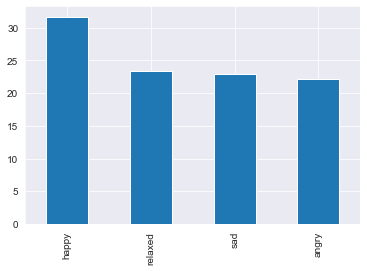

In [8]:
data['mood'].value_counts().div(data['mood'].value_counts().sum()).mul(100).plot(kind = 'bar')

<AxesSubplot:>

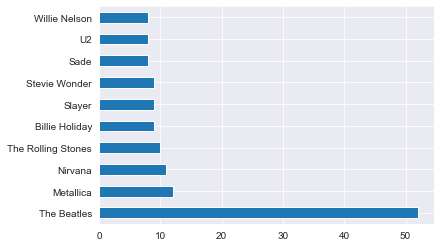

In [9]:
data['artist'].value_counts()[:10].plot(kind = 'barh')

<AxesSubplot:>

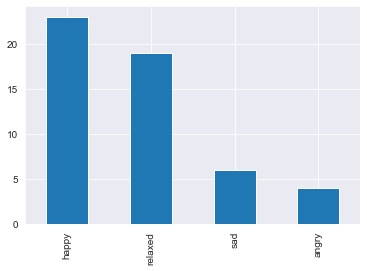

In [10]:
data[data['artist'] == 'The Beatles']['mood'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

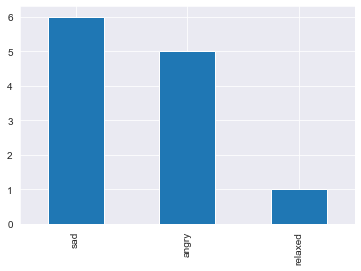

In [11]:
data[data['artist'] == 'Metallica']['mood'].value_counts().plot(kind = 'bar')

In [12]:
data.iloc[50]

artist                                               Shadows Fall
title                                             King Of Nothing
release_year                                                  NaN
album                                                 Retribution
lyrics          It was gone before you ever had a chance\nLost...
mood                                                        angry
Name: 50, dtype: object

In [13]:
string = data['lyrics'][0]
string

'[Produced by Jim Jonsin and Rico Love]\n\n[Intro]\nYeah... right...\nUsher baby... okay, yeah man\nRight... (turn the lights off)\n\n[Chorus]\nThere goes my baby\n(Oooh, girl, look at you)\nYou don\'t know how good it feels to call you my girl\nThere goes my baby\nLoving everything you do\nOooh, girl, look at you\n\n[Verse 1]\nBet you ain\'t know that I be checking you out when you be putting your heels on\nI swear, your body\'s so perfect, baby\nHow you work it, baby yeah, wooo!\nI love the way that you be poking it out, girl\nGive me something to feel on\nSo please believe we gone be twerking it out\nBy the end of the night, baby\n\n[Pre-Chorus]\nI\'ve been waiting all day to wrap my hands\nAround your waist and kiss your face\nWouldn\'t trade this feeling for nothing\n(Not even for a minute)\nAnd I\'ll sit here long as it takes\nTo get you all alone\nBut as soon as you come walking my way\nYou gon\' hear me say\n\n[Chorus]\nThere goes my baby\n(Oooh, girl, look at you)\nYou don\'t 

In [14]:
from utilities import preProcessing

In [15]:
# data['clean_lyrics'] = data['lyrics'].map(preProcessing)
# data.to_csv('preprocessed-data.csv', index = False)
data = pd.read_csv('preprocessed-data.csv')

In [20]:
clean_string = data['clean_lyrics'][0]
clean_string

"yeah right usher baby okay yeah man right go baby know good feel call girl go baby love everything oooh girl look bet ai know check put heel swear body perfect baby work baby yeah wooo love way poke girl give something feel please believe go twerking end night baby wait day wrap hand around waist kiss face would trade feel nothing sit long take get alone soon come walk way gon' hear say go baby know good feel call girl go baby love everything oooh girl look get chill whenever see face place girl feel like movie baby like oowee baby like waterfalls hair fall waist get taste girl need creep 'cause baby ai ashamed call name girl wait day wrap hand around waist kiss face would trade feel nothing even minute sit long take get alone soon come walk way gon' hear say go baby know good feel call girl go baby love everything oooh girl look girl feel like first time every time get together baby love feel better everything anything put heart need ring promise time away change love go baby know go

In [21]:
# function for generating word cloud
def plotWordCloud(data, label, text_col = 'clean_lyrics'):
    words = []
    for song_lyrics in data[text_col].iloc[:10]:
        for word in song_lyrics.split():
            words.append(word)
    words = ' '.join(words)
    
    wordcloud = WordCloud(contour_width=3, contour_color='steelblue').generate(words)

    # Display the generated image:
    fig = plt.figure(figsize = (10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(label, fontsize = 30)
    plt.axis("off")
    plt.margins(x = 0, y = 0)
    plt.show()

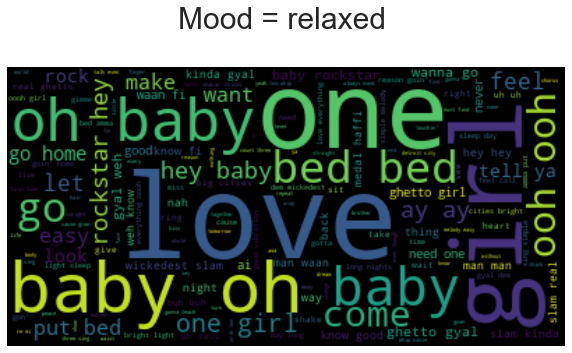

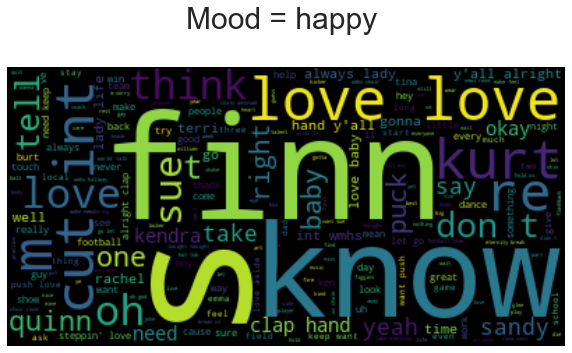

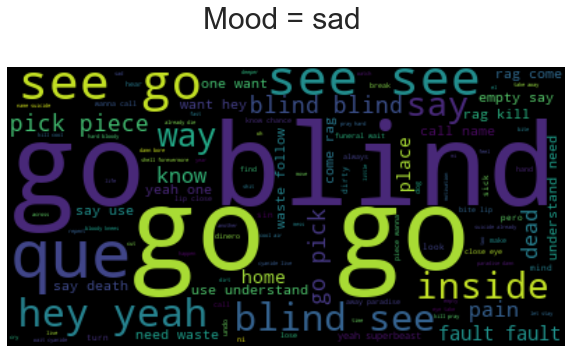

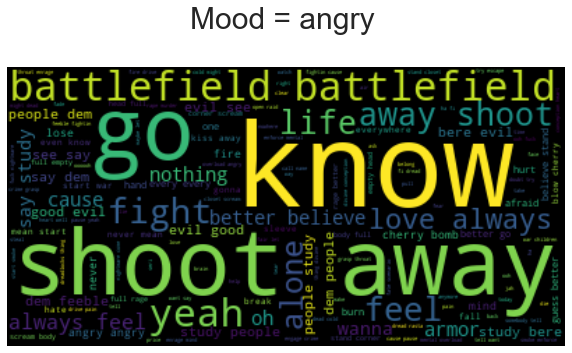

In [22]:
filtered_data = data[data['mood'] == 'relaxed']
plotWordCloud(filtered_data, label = 'Mood = relaxed \n')

filtered_data = data[data['mood'] == 'happy']
plotWordCloud(filtered_data, label = 'Mood = happy \n')

filtered_data = data[data['mood'] == 'sad']
plotWordCloud(filtered_data, label = 'Mood = sad \n')

filtered_data = data[data['mood'] == 'angry']
plotWordCloud(filtered_data, label = 'Mood = angry \n')

In [23]:
data = data[data['clean_lyrics'].notnull()]

In [24]:
X = data['clean_lyrics']
y = data['mood']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [26]:
vec = TfidfVectorizer()
X_train = vec.fit_transform(X_train)
pickle.dump(vec, open('vectorizer.pkl', 'wb'))
X_train

<1769x29054 sparse matrix of type '<class 'numpy.float64'>'
	with 139795 stored elements in Compressed Sparse Row format>

In [27]:
LR_clf = LogisticRegression()
scores = cross_val_score(LR_clf, X_train, y_train, scoring = 'accuracy', cv = 10)

In [28]:
print(f'Accuracy: {np.round(np.mean(scores) * 100, 2)}')

Accuracy: 90.0


In [29]:
LR_clf.fit(X_train, y_train)
pickle.dump(LR_clf, open('./models/LR_clf.pkl', 'wb'))

In [30]:
X_test = vec.transform(X_test)
X_test

<759x29054 sparse matrix of type '<class 'numpy.float64'>'
	with 57438 stored elements in Compressed Sparse Row format>

In [31]:
predictions = LR_clf.predict(X_test)
print(f'Accuracy: {np.round(accuracy_score(y_test, predictions) * 100, 2)}')

Accuracy: 90.78
